![title](notebook_images/logo.png)

# Biometrics System Concepts
# Assignment 3: Face Recognition
In this assignment, you will test/implement and report about a face recognition algorithm based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors that can be compared for verification/identification.

The structure of this document follows a typical face recognition pipeline and consists of the following major sections: 
1. Loading Image Data
2. Detecting faces in the images
3. Extracting features
4. Classification in typical biometrics setting
5. Advanced classification systems
6. Evaluation
7. Task


**Note: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

In [ ]:
import requests
import zipfile

## Note: This notebook is self contained and it can be executed directly on colab without uploading data. To do that you need to set DOWNLOAD_IMAGE = True

In [ ]:
DOWNLOAD_IMAGE = True

In [ ]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
if DOWNLOAD_IMAGE:
   share_able_link = "1g6pSp6b7ZM7D0Az4sdFrkXnbBcKDNX_3"
   destination  = "CalTechFacesDirs.zip"
   download_file_from_google_drive(share_able_link, destination)
   share_able_link = "16Y4j4ri99_794E3sVdoCUz9ZVsWl6EN0"
   destination  = "localmodules.zip"
   download_file_from_google_drive(share_able_link, destination)
   share_able_link = "1NQvRdObQiHPDrdPFJCov29nui5yKuQ1p"
   destination  = "models.zip"
   download_file_from_google_drive(share_able_link, destination)
   share_able_link = "1QG4kvkDJGU19QGen7UgSspINhqbiK1Zk"
   destination  = "notebook_images.zip"
   download_file_from_google_drive(share_able_link, destination)
   !unzip "CalTechFacesDirs.zip"
   !unzip "localmodules.zip"
   !unzip "models.zip"
   !unzip "notebook_images.zip"

Archive:  CalTechFacesDirs.zip
  inflating: CalTechFacesDirs/ImageData.mat  
   creating: CalTechFacesDirs/person_001/
   creating: CalTechFacesDirs/person_001/.ipynb_checkpoints/
  inflating: CalTechFacesDirs/person_001/.ipynb_checkpoints/image_0001-checkpoint.jpg  
  inflating: CalTechFacesDirs/person_001/.ipynb_checkpoints/image_0002-checkpoint.jpg  
  inflating: CalTechFacesDirs/person_001/.ipynb_checkpoints/image_0003-checkpoint.jpg  
  inflating: CalTechFacesDirs/person_001/.ipynb_checkpoints/image_0011-checkpoint.jpg  
  inflating: CalTechFacesDirs/person_001/.ipynb_checkpoints/image_0014-checkpoint.jpg  
  inflating: CalTechFacesDirs/person_001/.ipynb_checkpoints/image_0017-checkpoint.jpg  
  inflating: CalTechFacesDirs/person_001/.ipynb_checkpoints/image_0021-checkpoint.jpg  
  inflating: CalTechFacesDirs/person_001/image_0001.jpg  
  inflating: CalTechFacesDirs/person_001/image_0002.jpg  
  inflating: CalTechFacesDirs/person_001/image_0003.jpg  
  inflating: CalTechFacesDirs/

## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [ ]:
import numpy as np
import cv2
from pathlib import Path

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils

## 1. Loading an image datasets

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://www.cl.cam.ac.uk/research/dtg/attarchive/facesataglance.html) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1.1 Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. 

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [ ]:
# size of each face after preprocessing
face_size=(47, 47)

In [ ]:
import pandas as pd

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)
    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    

    return gray, imagePath.parent.name
     
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully (5 images were removed from the original set)
assert len(data['images']) == len(data['target']) == 445

### 2.2. Inspect some images

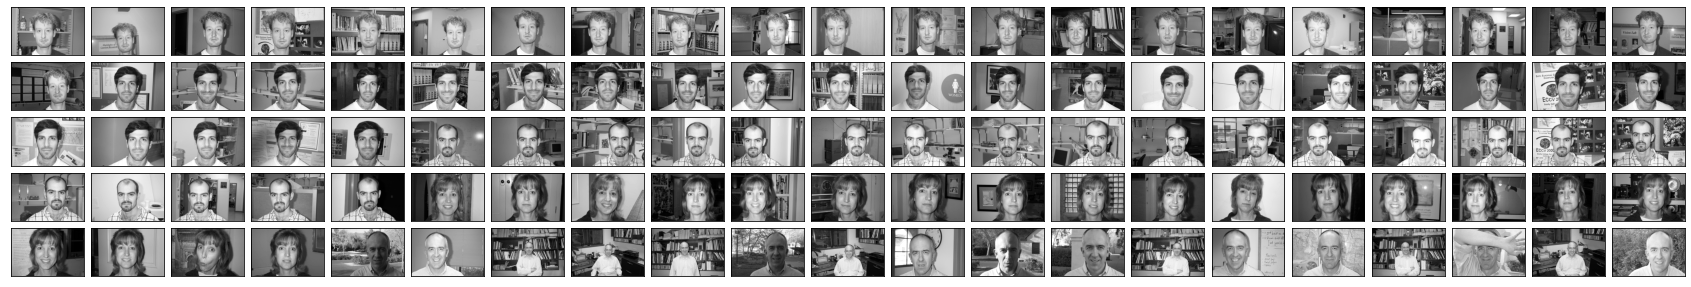

In [ ]:
fig = plt.figure(figsize=(30, 30))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## 2. Detecting faces


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 2.1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods. Please study the relevant publications on these detectors to understand their functioning.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html).

In [ ]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [ ]:
from sklearn.datasets.base import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []


for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


### 2.2. Print statistics of data

In [ ]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 2.3. Visualise some faces

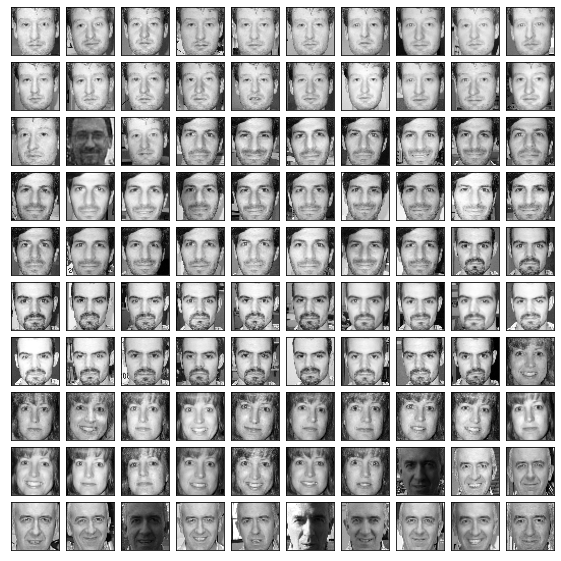

In [ ]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## 3. Feature Extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [ ]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.DL
######################################

# number of PCA/LDA components to retain
num_components = 35

### 3.1. Eigenfaces for face recognition

In 1971 Goldstein et al. ([Identification of human faces](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=1450184&url=http%3A%2F%2Fieeexplore.ieee.org%2Fxpls%2Fabs_all.jsp%3Farnumber%3D1450184)) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://gurus.pyimagesearch.com/wp-content/uploads/2015/10/kirby_1987.pdf)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images (presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [ ]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded = X_pca
    
    dist_metric = euclidean

In [ ]:
def get_pca_feature_vector(num_components,faces,n_samples, n_features):
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded = X_pca
    dist_metric = euclidean
    return embedded,dist_metric

### 3.2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is [Linear Discriminant Analysis (LDA)](http://www.scholarpedia.org/article/Linear_Discriminant_Analysis), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean
dist_metric = euclidean
if DESC == FeatureDescriptor.LDA:
    num_components = min(num_components, min(n_samples, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded = X_lda
    
    dist_metric = euclidean

In [ ]:
def get_LDA_feature_vector(num_components,faces,n_samples, n_features):
    num_components = min(num_components, min(n_samples, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded = X_lda
    dist_metric = euclidean
    return embedded,dist_metric

### 3.3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](http://www.outex.oulu.fi/publications/pami_02_opm.pdf) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [ ]:
from localmodules.local_binary_patterns import LBP
from scipy.stats import chisquare


if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded = desc.describe_list(faces.images[...,0])
    
    dist_metric = chisquare

In [ ]:
def get_LBP_feature_vector(faces):
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded = desc.describe_list(faces.images[...,0])
    dist_metric = euclidean
    return embedded,dist_metric

### 3.4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br> 


2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 

There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.



#### 3.4.1 Deep Metric Learning using Siamese Networks

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from (from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [ ]:
import localmodules.siamese as siamese

encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          894400      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]      

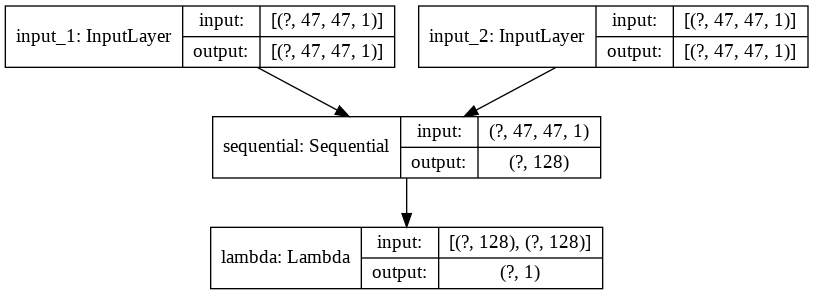

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [ ]:
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy])

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded = encoder(faces.images.astype(float)).numpy()

Epoch 1/10
38/38 - 1s - loss: 0.0924 - accuracy: 0.7385 - val_loss: 0.0617 - val_accuracy: 0.8510
Epoch 2/10
38/38 - 0s - loss: 0.0382 - accuracy: 0.9391 - val_loss: 0.0380 - val_accuracy: 0.9260
Epoch 3/10
38/38 - 0s - loss: 0.0235 - accuracy: 0.9704 - val_loss: 0.0279 - val_accuracy: 0.9781
Epoch 4/10
38/38 - 0s - loss: 0.0156 - accuracy: 0.9910 - val_loss: 0.0227 - val_accuracy: 0.9906
Epoch 5/10
38/38 - 0s - loss: 0.0114 - accuracy: 0.9967 - val_loss: 0.0192 - val_accuracy: 0.9906
Epoch 6/10
38/38 - 0s - loss: 0.0091 - accuracy: 0.9975 - val_loss: 0.0172 - val_accuracy: 0.9969
Epoch 7/10
38/38 - 0s - loss: 0.0072 - accuracy: 0.9984 - val_loss: 0.0162 - val_accuracy: 0.9969
Epoch 8/10
38/38 - 0s - loss: 0.0060 - accuracy: 0.9992 - val_loss: 0.0153 - val_accuracy: 0.9969
Epoch 9/10
38/38 - 0s - loss: 0.0048 - accuracy: 0.9992 - val_loss: 0.0139 - val_accuracy: 0.9969
Epoch 10/10
38/38 - 0s - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.0127 - val_accuracy: 0.9969
Accuracy on the tes

In [ ]:
def get_deep_feature_vector(faces):
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy])

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded = encoder(faces.images.astype(float)).numpy()
    return embedded,dist_metric

## 4. Classification in typical biometrics setting

#### <font color=blue> Task 1: Compute pair-wise matching scores
Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. 

#### The first step is to compute the distance matrix. We used the existing dist_metric function to compute the pairwise distance and store it in a 2x2 matrix.

In [ ]:
def get_pairwise_distances(matrix,targets,dist_metric):
  #Get the size of the matrix.
  rows,cols = matrix.shape

  #Next, We create two matrices. 
  #dist_matrix contains pairwise distances between every two pairs.
  dist_matrix = [[0 for x in range(rows)] for y in range(rows)]
  genuine_mask = [[0 for x in range(rows)] for y in range(rows)]  

  #Now, we go through each and every pair, compute their distances and store it in the matrix.
  for i in range(rows):
     for j in range(rows):
         dist_matrix[i][j] = dist_matrix[i][j] + dist_metric(matrix[i],matrix[j])

         #If two pairs have same targets then they belong to genuine matrix.
         if(targets[i] == targets[j]):
            genuine_mask[i][j] = 1
  #Finally, the result is returned.
  return np.array(dist_matrix),np.array(genuine_mask)

#### The Values of the distance matrix that we computed in previous section, have infinite range so we need to convert it into similarity matrix. Next function converts the distance matrix into similarity matrix.

In [ ]:
def get_similarity_matrix(distance_matrix):

    #We first normalize the scores by dividing each score by the sum of the same row.
    row_sums = distance_matrix.sum(axis=1)
    distance_matrix_n = distance_matrix / row_sums[:, np.newaxis]

    #Next, we subtract each score by 1 to inver the distance to similarity.
    similarity_matrix = 1- distance_matrix_n
    return similarity_matrix
    

###We finally compute the distance matrix for embedded with targets as given above. We also convert the distance matrix to similarity matrix.

In [ ]:
#Compute the distance matrix and it's mask_id which contains 1 if the score at that index in distance_matrix belongs to genuine distribution.
distance_matrix,mask_id  = get_pairwise_distances(embedded,faces.target,dist_metric)
#Finally, distance matrix is converted to the similarity matrix.
similarity_matrix = get_similarity_matrix(distance_matrix)

In [ ]:
def get_sim_matrix(matrix,targets,dist_metric):
    distance_matrix,mask_id  = get_pairwise_distances(matrix,targets,dist_metric)
    similarity_matrix = get_similarity_matrix(distance_matrix)
    return similarity_matrix.flatten(),mask_id.flatten()

#### Finally distance matrix and mask_id matrix are converted to 1d array/list.

In [ ]:
distance_matrix_n = similarity_matrix.flatten()
mask_id = mask_id.flatten()

## 5. Advanced Classification Scenario
Biometrics classification is based on generating pairwise matching scores. 
* In verification mode one compares this matching score to a decision threshold in a 1-to-1 classification setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N classification setting

Hence, a simple pairwise comparision (L2-distance, e.g.) can be used. 

In a more general classification scenario one can use the feature representations to build more complex classifiers (SVM, NN, etc.). Testing then requires a splitting in training and validation subsets. 

Here you find an example with KNN and SVM as classifiers and their validation results. 

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Holdout on dataset
X_train_class, X_test_class, y_train_class, y_test_class = holdout_split(embedded, faces.target)

### KNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train_class, y_train_class)

acc_knn = accuracy_score(y_test_class, knn.predict(X_test_class))
print(f'KNN accuracy = {acc_knn}')

KNN accuracy = 0.9818181818181818


## 6. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments

### 6.1. Validation as verification system

#### <font color=blue> Task 2: Compute F1 and accuracy scores for variable (and optimal) thresholds

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature)

In [ ]:
from sklearn.metrics import f1_score


#### We need a function that generates a list of thresholds based on the parameters it takes.

In [ ]:
#step_size: Step size of the threshold. It determines the distance between two consecutive thresholds.
#start_threshold: The starting threshold(min_threshold) and the max threshold is by default 1.
def get_threshold_array(step_size,start_threshold):

    #Initialize the thresholds array.
    thresholds = []

    #Set the threshold equal to start_threshold.
    threshold = start_threshold

    #Initialize the step_size.
    step = step_size

    #While the threshold is not 1.
    while (threshold < 1):
        #Add the threshold to list.
        thresholds.append(threshold)
        #Increment the threshold.
        threshold = threshold + step
    #Finally add the threshold 1.
    thresholds.append(1)
    #Return the threshold.
    return thresholds

##### The following function returns 1 if the score is greater than threshold otherwise 0 will be returned.

In [ ]:
#This function returns 1 if score is greater than threshold otherwise 0.
def get_predicted_labels(threshold,score):
    if(score > threshold):
        return 1
    else:
        return 0
    

#### Following function computes the values of F-score or accuracy based on given input parameters.

In [ ]:
#y_true: A vector/list containing the true labels.
#scores: The predicted scores.
#thresholds: A list of thresholds that will be used to find the correctly classified instances.
#text: This text determines either f-score or accuracy.
def get_performance_metrics(y_true,scores,thresholds,text):
    
    #The length of the scores.
    total_scores = len(scores)
    #The length of the thresholds.
    len_of_thresholds = len(thresholds)
    #List where we will collect the result.
    values = []

    #Now loop through all thresholds and for each threshold predict the labels based on the threshold.
    for i in range(len_of_thresholds):
        predicted_labesl = []

        #For each score, find out if it is correctly predicted or not and save it in predicted_labels list.
        for j in range(total_scores):
            predicted_labesl.append(get_predicted_labels(thresholds[i],scores[j]))                
        
        #Check for the correction.
        assert(len(predicted_labesl) == total_scores)

        #Based on the text, compute the accuracy or f-score of true and predicted labels and save it to return later.
        if(text == "acc"):
            values.append(accuracy_score(y_true, predicted_labesl))
        elif(text == "F1"):
            values.append(f1_score(y_true, predicted_labesl))
    return values


#### We now finally start with a specific threshold and compute thresholds.

In [ ]:
start_threshold = 0
thresholds = []
#If we are using deep learning then if the min threshold is not selected correctly then it does not show a good/informative curve.
if DESC == FeatureDescriptor.DL:
   start_threshold = np.amin(distance_matrix_n)
   thresholds = get_threshold_array(0.0002,start_threshold)
else:
   start_threshold = np.amin(distance_matrix_n)
   thresholds = get_threshold_array(0.0002,start_threshold)

#### We finally compute the F-score and accuracy.

In [ ]:
f_score = get_performance_metrics(mask_id,distance_matrix_n,thresholds,"F1")
accuracy = get_performance_metrics(mask_id,distance_matrix_n,thresholds,"acc")

####Following function takes number of inputs and plots them in 2-D.

In [ ]:
def plot_socres(thresholds,values,axes,y_label,x_label,title,label,color_curve):
    axes.plot(thresholds,values,color=color_curve,marker=".",label=label)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.title.set_text(title)

####Plot the accuracy and F-score.

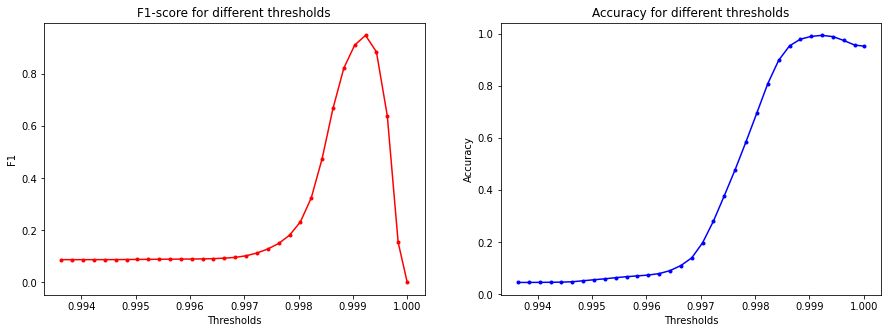

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_socres(thresholds,f_score,axes[0],'F1',"Thresholds","F1-score for different thresholds",label="F",color_curve = "RED")
plot_socres(thresholds,accuracy,axes[1],'Accuracy',"Thresholds","Accuracy for different thresholds",label="Accuracy",color_curve="BLUE")
plt.show()

#### <font color=blue> Task 3: Plot genuine and impostor scores

#### In this section, we will plot genuine and imposter socres.

In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### We now seperate the genuine distribution from the imposter to plot it.

In [ ]:
def get_genuine_imposter_score(mask_id,distance_matrix_n):
    #Initialize the empty lists.
    genuine_dist = []
    imposter_dist = []

    #Go through each mask id in the mask_id array.
    #If the ID is 1 at index i then append the score from distance matrix from index i to the genuine array.
    #If the ID is 0 at index i then append the score from distance matrix from index i to the imposter array.
    for i in range(len(mask_id)):
      if (mask_id[i] == 1):
         genuine_dist.append(distance_matrix_n[i])
      else:
         imposter_dist.append(distance_matrix_n[i])
#Control if all elements are processed.
    assert (len(genuine_dist) + len(imposter_dist) == len(distance_matrix_n))
    return genuine_dist,imposter_dist

#### Next, we separate the genuine and imposter scores to plot them in different axis.

In [ ]:
genuine_dist,imposter_dist = get_genuine_imposter_score(mask_id,distance_matrix_n)

#### The following section plots the distrbutions.

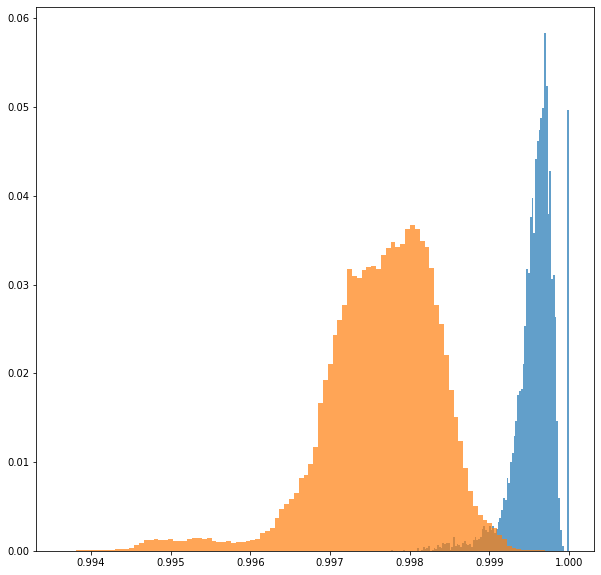

In [ ]:
#Set the size of the figure.
plt.figure(figsize=(10,10))
#First create the weights for normalized version of the plots.
weights = np.ones_like(genuine_dist)/float(len(genuine_dist))
weights2 = np.ones_like(imposter_dist)/float(len(imposter_dist))
#Parameters that define type of the curve and number of bins.
kwargs = dict(histtype='stepfilled', alpha=0.7,  bins=100)
#Finally plot the histogram.
plt.hist(genuine_dist,**kwargs, weights=weights)
plt.hist(imposter_dist,**kwargs, weights=weights2)
plt.show()

#### <font color=blue> Task 4: Calculate Equal Error Rate

#### In this section, we will compute the EER.

##### The following function is used to compute the FAR and FRR.

In [ ]:
#scores: Sorted list of all scores
#list_of_dist_vals: list of distribution(also sorted in reverse order for efficiency reason )
def get_list_of_increasing_number(scores,list_of_dist_vals):
    #This parameter is used for efficiency reason(in order to avoid repetitive work).
    previous_j = 0
    previous_sum = 0
    total_greater_values = 0
    #Get the length of all scores.
    len_of_scores = len(scores)
    #Get length of distribution list.
    len_of_dist_list = len(list_of_dist_vals)
    #Initialize the list that will contain final result.
    to_return_list = []
    #For each score value k, count how many values in distribution list are greater than k.
    for i in range(len_of_scores):
        total_greater_values = previous_sum
        for j in range(previous_j,len_of_dist_list):
            if(list_of_dist_vals[j] >= scores[i]):
                total_greater_values = total_greater_values + 1
            #If at any time distribution value is less that score value then break because both lists are sorted in opposite order.
            elif (list_of_dist_vals[j] < scores[i]):
                previous_j = j
                previous_sum = total_greater_values
                break
        #Normalize the result.
        normalized = ((total_greater_values))/len_of_dist_list
        #Add this value at position corresponding to the score index.
        to_return_list.append(normalized)
    return to_return_list

##### In the next section, we will call this function to get results from the method defined above.

In [ ]:
def get_FAR_FRR(distance_matrix_n,genuine_dist,imposter_dist):
  #Sort the whole distance matrix in reverse order.
  sorted_score = sorted(distance_matrix_n,reverse=True)
  #Sort the imposter distribution in the reverse order.
  sorted_imposter = sorted(imposter_dist,reverse=True)
  #Sort the genuine score in also in opposite order.
  sorted_genuine_score = sorted(genuine_dist,reverse=True)
  #Finally we get the lists of FMR AND FRR.
  FMR_list = get_list_of_increasing_number(sorted_score,sorted_imposter)
  FRR_list = get_list_of_increasing_number(sorted_score,sorted_genuine_score)
  #Sort the FRR again in reverse order.
  FRR_list.sort(reverse=True)
  return FMR_list,FRR_list,sorted_score

In [ ]:
FMR_list,FRR_list,sorted_score = get_FAR_FRR(distance_matrix_n,genuine_dist,imposter_dist)

##### In the next section, we will calculate the EER-point. It is a point where FMR intersects FRR. We simply pick the FIRST point where FMR becomes greater than FRR.

In [ ]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
# hints:
#  - you can use an interpolated or discrete approximation, both are fine
#  - avoid using a library for this assignment 

def get_eer_point(FMR_list,FRR_list):
  index_EER = -1
  for i in range(len(FMR_list)):
    if FMR_list[i] >= FRR_list[i]:
       index_EER = i
       break
  return index_EER

##### Now, we call the above function to get the index of EER-point.

In [ ]:
index_EER = get_eer_point(FMR_list,FRR_list)

#####Next, we find the coordinates based on the founded index.

In [ ]:
point_eer = pd.DataFrame({'x': [sorted_score[index_EER]], 'y': [(FMR_list[index_EER]+FRR_list[index_EER])/2]})

##### Finally, we plot FMR and FRR with it's EER_point.

In [ ]:
def plot_FMR_FRR_EER(sorted_score,FMR_list,FRR_list):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
    axes.scatter(point_eer['x'], point_eer['y'], marker='o', color='r', label='EER')
    axes.legend(loc='upper left')
    axes.plot(sorted_score,FMR_list,color="BLUE",marker="",label='FMR')
    axes.plot(sorted_score,FRR_list,color="BLACK",marker="",label='FRR')
    axes.legend(loc="upper right")
    axes.title.set_text("Left index FMR & FRR")
    axes.set_xlabel('Scores/Threshold')
    axes.set_ylabel('% FMR or FRR')
    plt.show()

##### Finally the function is called to plot FMR,FRR and EER.

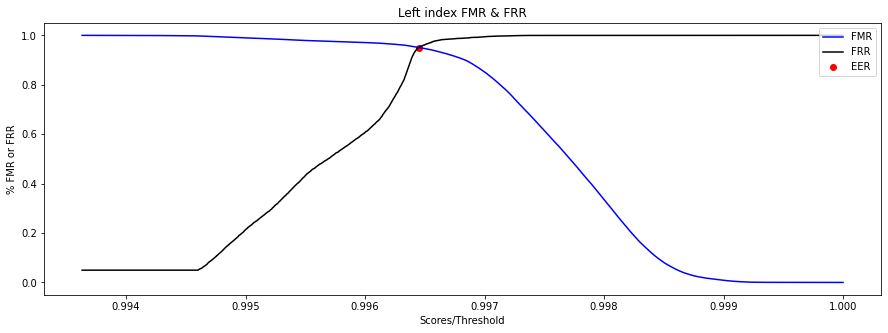

In [ ]:
plot_FMR_FRR_EER(sorted_score,FMR_list,FRR_list)

#### EER is a point where FMR and FRR intersect each other and we want to it be low which is not the case. 

#### <font color=blue> Task 5: Calculate classification scores
* plot precision-recall curve
* calculate AUC
* average precision

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import sklearn.metrics as metrics

##### In this section, precision and recall is calculated for different thresholds by using a built in function.

In [ ]:
precision, recall, thresholds = precision_recall_curve(mask_id, distance_matrix_n)


##### Next we build a function that can plot precision and recall.

In [ ]:
def plot_precision_recall(recall,precision):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    axes.plot(recall,precision,color="RED",label='PR/RE')
    axes.set_xlabel("Recall")
    axes.set_ylabel("Precision")
    axes.title.set_text("Precision/Recall")
    plt.show()

#####Now, the function plot_precision_recall, is called to plot the data.

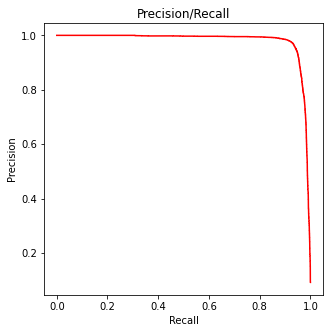

In [ ]:
plot_precision_recall(recall,precision)

In [ ]:
"""Calculate the Area Under the PR-curve."""
area = metrics.auc(recall,precision)
print("Area under PR-curve  is ", area)
print()


Area under PR-curve  is  0.980122173949526



In [ ]:
"""Calculate the average precision scores"""
avg_pr_scores = average_precision_score(mask_id,distance_matrix_n)
print("The average precision is ",avg_pr_scores)


The average precision is  0.980122954083412


## 6.2 Validation as identification system

#### <font color=blue> Task 6: Generate a Cumulative Matching Curve

In [ ]:
import random


In [ ]:
def get_all_images_for(index,embedded,targets,unique_targets):
    indexes = np.where(targets == index)
    indexes = indexes[0]
    result_array = np.zeros(shape=(len(indexes),128))
    for i in range(len(indexes)):
        result_array[i] = embedded[indexes[i]]
    return result_array

In [ ]:
def sample_and_compare_vec(gallery_first,gallery_second,equal_ind):
    assert len(gallery_first) > 0
    assert len(gallery_second) > 0
    total_sum = 0
    for i in range(len(gallery_first)):
      sum = 0
      for j in range(len(gallery_second)):
        if (equal_ind and j != i):
           sum = sum + (dist_metric(gallery_first[i],gallery_second[j]))
        elif (not equal_ind):
           sum = sum + (dist_metric(gallery_first[i],gallery_second[j]))
      if (equal_ind):
         sum = sum/(len(gallery_second)-1)
      else:
         sum = sum/len(gallery_second)
      total_sum = total_sum+sum
    return sum


In [ ]:
def get_cmc_for(embedded,targets):
    flatted_vector = embedded
    flatted_targets = targets
    unique_targets = list(set(flatted_targets))
    cmc_matrix = [[0 for x in range(len(unique_targets))] for y in range(len(unique_targets))] 
    for i in range(len(unique_targets)):
        for j in range(len(unique_targets)):
            equal_ind = False
            gallery_first = get_all_images_for(i,embedded,faces.target,len(unique_targets))
            gallery_second =  get_all_images_for(j,embedded,faces.target,len(unique_targets))
            result = sample_and_compare_vec(gallery_first,gallery_second,equal_ind)
            cmc_matrix[i][j] = result
    return np.array(cmc_matrix)

In [ ]:
cmc_matrix = get_cmc_for(embedded,faces.target)

In [ ]:
display(cmc_matrix.shape)

(26, 26)

In [ ]:
"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library


def CMC(similarity_matrix, n_ranks):
    copy = similarity_matrix.copy()
    rows,cols = copy.shape
    ranks_count = [0]*n_ranks 
    normalized = [0]*n_ranks
    for i in range(0,rows):
        element = copy[i][i]
        row = list(copy[1])
        row = sorted(row,reverse=True)
        greater_vals = len([i for i in row if i >= element])
        if(greater_vals < n_ranks):
           val = ranks_count[greater_vals]
           val = val+1
           ranks_count[greater_vals] = val
    total_sum = 0
    for i in range(0,n_ranks):
      total_sum = total_sum + ranks_count[i]
      normalized[i] = total_sum/rows
    # 1.1) compute the rank of the column elements (enrollees) for every row (user)
    # 1.2) calculate how frequent each rank occurs on the diagonal (diagonal contains the correct identifications)  
    # 1.3) compute the cumalulative frequency for each rank and normalise the result 
    # 1.4) return the CMC

    return normalized

# 1) compute the CMC for the first ±100 ranks
n_ranks = 99

# 2) plot the probability of recognition in function of the rank
result_ri = CMC(cmc_matrix,n_ranks)

In [ ]:
ranks = []
for i in range(1,n_ranks+1):
    ranks.append(i) 

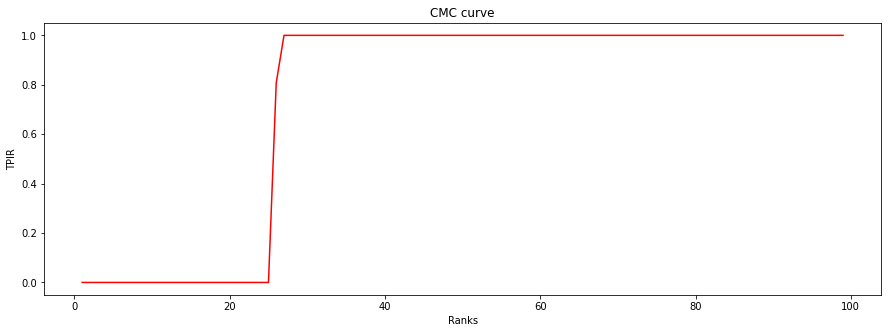

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
axes.plot(ranks,result_ri,color="RED",marker="",label='RightIndex')
axes.set_xlabel("Ranks")
axes.set_ylabel("TPIR")
axes.title.set_text("CMC curve")
plt.show()

## 6.2 Validation in multi-classification setting
#### <font color=blue> Task 7: Validate the advanced classification scenario
You can choose an appropriate metric. 

## 7. Task
All tasks should be accompanied by a text providing information on; the technique, the steps, and, the reasoning behind choosing the techniques.

<em>Note: in case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. </em>

### 7.1. Mandatory tasks
<b>The student should do all of the tasks indicated below</b>: 
1. Execute all the tasks indicated in the document above
2. Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics and report on the performance below (you can for instance store your intermediary results/plots in a file and plot them below).

#### Here we compare the results from all 4 techniques.
#####First we need to compute the embeddings which will be used as input.

In [ ]:
embedded_vector_pca,dist_pca = get_pca_feature_vector(num_components,faces,n_samples, n_features)
embedded_vector_LDA,dist_LDA = get_LDA_feature_vector(num_components,faces,n_samples, n_features)
embedded_vector_deep,dist_deep = get_deep_feature_vector(faces)
embedded_vector_LBP,dist_LBP = get_LBP_feature_vector(faces)

num_components 35


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(2209, 26 - 1) = 25 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(2209, 26 - 1) = 25 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_comp

Epoch 1/10
38/38 - 0s - loss: 0.0125 - accuracy: 0.9926 - val_loss: 0.0122 - val_accuracy: 0.9969
Epoch 2/10
38/38 - 0s - loss: 0.0080 - accuracy: 0.9984 - val_loss: 0.0108 - val_accuracy: 0.9969
Epoch 3/10
38/38 - 0s - loss: 0.0060 - accuracy: 0.9992 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 4/10
38/38 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 0.9854
Epoch 5/10
38/38 - 0s - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0077 - val_accuracy: 0.9885
Epoch 6/10
38/38 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 7/10
38/38 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9917
Epoch 8/10
38/38 - 0s - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.0064 - val_accuracy: 0.9885
Epoch 9/10
38/38 - 0s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9885
Epoch 10/10
38/38 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9885
Accuracy on the tes

#####Compute the thresholds along which the values will be printed.

In [ ]:
start_threshold = np.amin(distance_matrix_n)
thresholds = get_threshold_array(0.0002,start_threshold)

#####Create the similarity vectors for all types.

In [ ]:
sim_vector_pca,mask_pca = get_sim_matrix(embedded_vector_pca,faces.target,dist_pca)
sim_vector_LDA,mask_LDA = get_sim_matrix(embedded_vector_LDA,faces.target,dist_LDA)
sim_vector_deep,mask_deep = get_sim_matrix(embedded_vector_deep,faces.target,dist_deep)
sim_vector_LBP,mask_LBP = get_sim_matrix(embedded_vector_LBP,faces.target,dist_LBP)

#####Compute the F-score and accuracy for each of these techniques.

In [ ]:
f_score_pca = get_performance_metrics(mask_pca,sim_vector_pca,thresholds,"F1")
accuracy_pca = get_performance_metrics(mask_pca,sim_vector_pca,thresholds,"acc")

f_score_LDA = get_performance_metrics(mask_LDA,sim_vector_LDA,thresholds,"F1")
accuracy_LDA = get_performance_metrics(mask_LDA,sim_vector_LDA,thresholds,"acc")

f_score_deep = get_performance_metrics(mask_deep,sim_vector_deep,thresholds,"F1")
accuracy_deep = get_performance_metrics(mask_deep,sim_vector_deep,thresholds,"acc")

f_score_LBP = get_performance_metrics(mask_LBP,sim_vector_LBP,thresholds,"F1")
accuracy_LBP = get_performance_metrics(mask_LBP,sim_vector_LBP,thresholds,"acc")

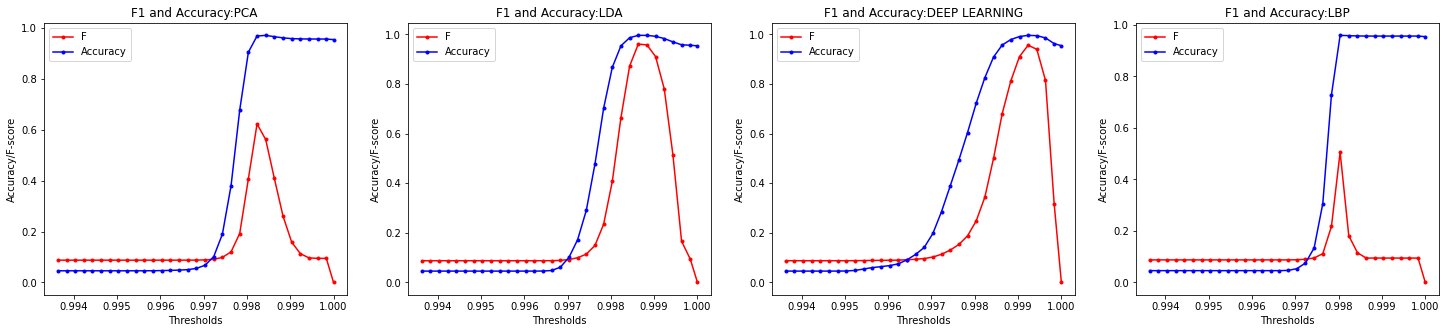

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))
lists = []
line = plot_socres(thresholds,f_score_pca,axes[0],'F1',"Thresholds","",label="F",color_curve = "RED")
plot_socres(thresholds,accuracy_pca,axes[0],'Accuracy/F-score',"Thresholds","F1 and Accuracy:PCA ",label="Accuracy",color_curve="BLUE")
axes[0].legend()
plot_socres(thresholds,f_score_LDA,axes[1],'F1',"Thresholds","F1-score for different thresholds",label="F",color_curve = "RED")
plot_socres(thresholds,accuracy_LDA,axes[1],'Accuracy/F-score',"Thresholds","F1 and Accuracy:LDA",label="Accuracy",color_curve="BLUE")
axes[1].legend()
plot_socres(thresholds,f_score_deep,axes[2],'F1',"Thresholds","F1-score for different thresholds",label="F",color_curve = "RED")
plot_socres(thresholds,accuracy_deep,axes[2],'Accuracy/F-score',"Thresholds","F1 and Accuracy:DEEP LEARNING",label="Accuracy",color_curve="BLUE")
axes[2].legend()
plot_socres(thresholds,f_score_LBP,axes[3],'F1',"Thresholds","F1-score for different thresholds",label="F",color_curve = "RED")
plot_socres(thresholds,accuracy_LBP,axes[3],'Accuracy/F-score',"Thresholds","F1 and Accuracy:LBP",label="Accuracy",color_curve="BLUE")
axes[3].legend()
plt.show()

####Now we will plot the distribution for all these techniques.

In [ ]:
genuine = [0]*5
imposter = [0]*5
labels = []
genuine[0],imposter[0] = get_genuine_imposter_score(mask_pca,sim_vector_pca)
labels.append("PCA")
genuine[1],imposter[1] = get_genuine_imposter_score(mask_LDA,sim_vector_LDA)
labels.append("LDA")
genuine[2],imposter[2]  = get_genuine_imposter_score(mask_deep,sim_vector_deep)
labels.append("Deep Learning")
genuine[3],imposter[3]  = get_genuine_imposter_score(mask_LBP,sim_vector_LBP)
labels.append("LBP")

#### A function that will plot the distributions.

In [ ]:
def plot_dist(col,genuine_dist,imposter_dist,label):
    weights = np.ones_like(genuine_dist)/float(len(genuine_dist))
    weights2 = np.ones_like(imposter_dist)/float(len(imposter_dist))
    #Parameters that define type of the curve and number of bins.
    kwargs = dict(histtype='stepfilled', alpha=0.7,  bins=100)
    #Finally plot the histogram.
    col.hist(genuine_dist,**kwargs, weights=weights,label='genuine_dist')
    col.hist(imposter_dist,**kwargs, weights=weights2,label='imposter_dist')
    col.legend()
    col.title.set_text(label)

#### Next we go through each of the window and plot the distribution with it's labels.

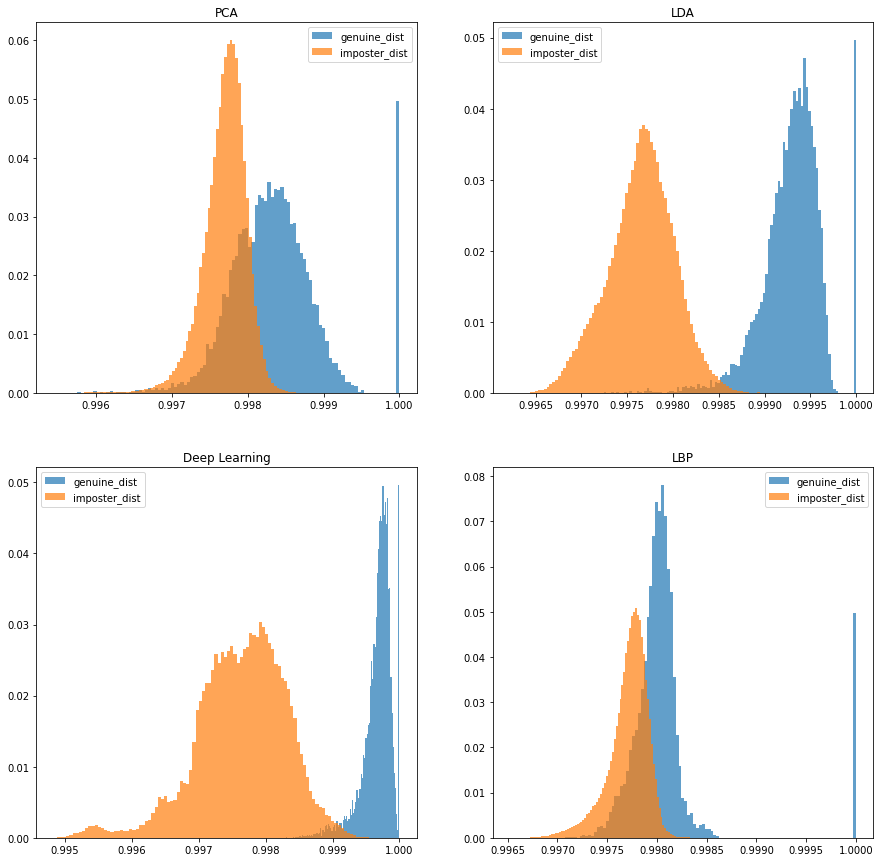

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
index = 0
for row in ax:
    for col in row:
        plot_dist(col,genuine[index],imposter[index],labels[index])
        index = index+1
plt.show()

####Next we calculate FMR and FRR for each of these techniques.

In [ ]:
FMR_PCA,FRR_PCA,sorted_score_PCA = get_FAR_FRR(sim_vector_pca,genuine[0],imposter[0])
FMR_LDA,FRR_LDA,sorted_score_LDA = get_FAR_FRR(sim_vector_LDA,genuine[1],imposter[1])
FMR_deep,FRR_deep,sorted_score_deep = get_FAR_FRR(sim_vector_LDA,genuine[2],imposter[2])
FMR_LBP,FRR_LBP,sorted_score_LBP = get_FAR_FRR(sim_vector_LDA,genuine[3],imposter[3])

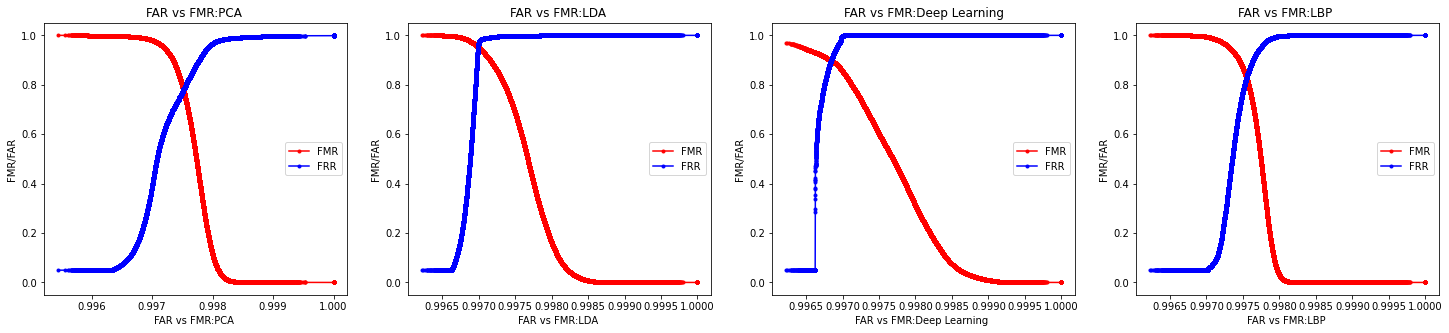

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))
plot_socres(sorted_score_PCA,FMR_PCA,axes[0],'FMR/FAR',"","",label="FMR",color_curve = "RED")
plot_socres(sorted_score_PCA,FRR_PCA,axes[0],'FMR/FAR',"FAR vs FMR:PCA ","FAR vs FMR:PCA ",label="FRR",color_curve="BLUE")
axes[0].legend()
plot_socres(sorted_score_LDA,FMR_LDA,axes[1],'FMR/FAR',"","",label="FMR",color_curve = "RED")
plot_socres(sorted_score_LDA,FRR_LDA,axes[1],'FMR/FAR',"FAR vs FMR:LDA ","FAR vs FMR:LDA ",label="FRR",color_curve="BLUE")
axes[1].legend()
plot_socres(sorted_score_deep,FMR_deep,axes[2],'FMR/FAR',"","",label="FMR",color_curve = "RED")
plot_socres(sorted_score_deep,FRR_deep,axes[2],'FMR/FAR',"FAR vs FMR:Deep Learning ","FAR vs FMR:Deep Learning",label="FRR",color_curve="BLUE")
axes[2].legend()
plot_socres(sorted_score_LBP,FMR_LBP,axes[3],'FMR/FAR',"","FAR vs FMR ",label="FMR",color_curve = "RED")
plot_socres(sorted_score_LBP,FRR_LBP,axes[3],'FMR/FAR',"FAR vs FMR:LBP ","FAR vs FMR:LBP ",label="FRR",color_curve="BLUE")
axes[3].legend()


####Next we compute precision and recall and then we will plot it.

In [ ]:
precision_PCA, recall_PCA, thresholds_PCA = precision_recall_curve(mask_pca, sim_vector_pca)
precision_LDA, recall_LDA, thresholds_LDA = precision_recall_curve(mask_LDA, sim_vector_LDA)
precision_deep, recall_deep, thresholds_deep = precision_recall_curve(mask_deep, sim_vector_deep)
precision_LBP, recall_LBP, thresholds_LBP = precision_recall_curve(mask_LBP, sim_vector_LBP)

#### Now we plot the precision recall curves.

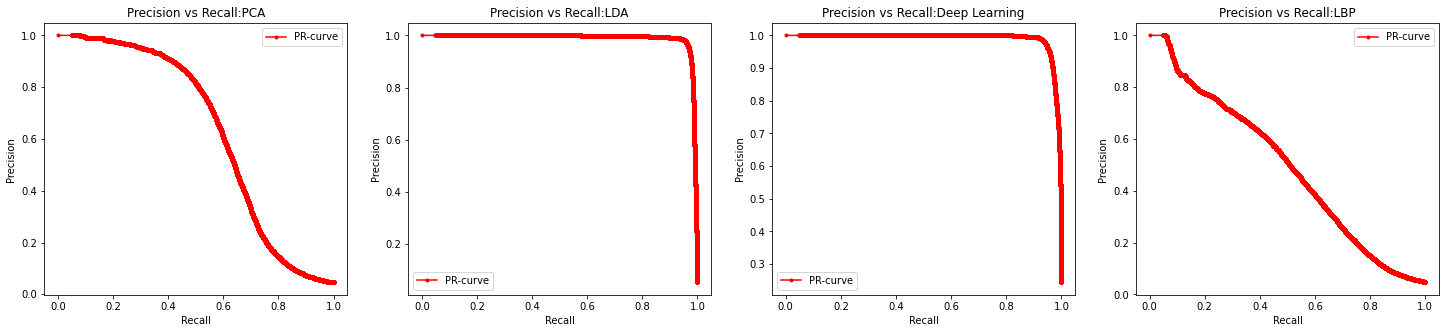

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))
plot_socres(recall_PCA,precision_PCA,axes[0],'Precision ',"Recall","Precision vs Recall:PCA",label="PR-curve",color_curve = "RED")
axes[0].legend()
plot_socres(recall_LDA,precision_LDA,axes[1],'Precision',"Recall","Precision vs Recall:LDA",label="PR-curve",color_curve = "RED")
axes[1].legend()
plot_socres(recall_deep,precision_deep,axes[2],'Precision',"Recall","Precision vs Recall:Deep Learning",label="PR-curve",color_curve = "RED")
axes[2].legend()
plot_socres(recall_LBP,precision_LBP,axes[3],'Precision ',"Recall","Precision vs Recall:LBP",label="PR-curve",color_curve = "RED")
axes[3].legend()

####From the precision-recall curves, we see that LDA and deep learning perform better than LBP and PCA.

### 7.2. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. Evaluate your system on the other two datasets (AT&T, LFW) (1pt.)
2. Implement 2 different face detectors and compare all techniques to the to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. (1pt.)
3. Develop a new advanced classifier (beyond KNN) and compare the results with the current KNN classifier. (1pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and compare the results. (1pt.) 
6. Implement a different deep learning model* (2pt.)

e.g. performing task 6 and 5 is valid because their points sum up to 3. 

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters, activation functions does not count.

##Download the images

In [ ]:
#!wget -nc https://www.robots.ox.ac.uk/~vgg/data/vgg_face/vgg_face_dataset.tar.gz


In [ ]:
#!tar -xf vgg_face_dataset.tar.gz --totals


In [ ]:
import os
import io
import requests
from PIL import Image
from urllib import request
from google.colab.patches import cv2_imshow
import urllib.request
import requests


In [ ]:
#all_files = os.listdir("vgg_face_dataset/files")
#all_files = sorted(all_files)
#display(all_files)

In [ ]:
#TOTAL_IMAGES = 50


In [ ]:
"""def dowload(url_img):
    img   = None
    try :
        r = requests.get(url_img)
        with open('a.jpg', 'wb') as f:
           f.write(r.content)
        img = cv2.imread('a.jpg', cv2.IMREAD_GRAYSCALE)
    except :
        img = None
    if os.path.exists("a.jpg"):
       os.remove("a.jpg")
    return img"""

'def dowload(url_img):\n    img   = None\n    try :\n        r = requests.get(url_img)\n        with open(\'a.jpg\', \'wb\') as f:\n           f.write(r.content)\n        img = cv2.imread(\'a.jpg\', cv2.IMREAD_GRAYSCALE)\n    except :\n        img = None\n    if os.path.exists("a.jpg"):\n       os.remove("a.jpg")\n    return img'

In [ ]:
"""def crop_image(img,img_info):
    face = []
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30)
    )
    for (x, y, w, h) in faces:
        new_img = img.copy()
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]
        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
    return face"""

'def crop_image(img,img_info):\n    face = []\n    faces = faceCascade.detectMultiScale(\n        img,\n        scaleFactor = 1.2,\n        minNeighbors = 9,\n        minSize = (30, 30)\n    )\n    for (x, y, w, h) in faces:\n        new_img = img.copy()\n        # extract ROI\n        raw_face = new_img[y:y+h, x:x+w]\n        # resize the face to the preferred size\n        face = cv2.resize(raw_face, face_size)\n        face_flatten = face.flatten()\n    return face'

In [ ]:
"""def read_vgg_images(path,fileName):
    f = open(path+fileName, "r")
    image_per_person = []
    targets_cor = []
    NoneType = type(None)
    for i in range(TOTAL_IMAGES):
        line = f.readline().split(" ")
        image = dowload(line[1])
        if (type(image) != NoneType):
              if(len(image) != 0):
                if (image is not None):
                    image = crop_image(image,line)
                    image_per_person.append(image)
    return np.array(image_per_person)"""

'def read_vgg_images(path,fileName):\n    f = open(path+fileName, "r")\n    image_per_person = []\n    targets_cor = []\n    NoneType = type(None)\n    for i in range(TOTAL_IMAGES):\n        line = f.readline().split(" ")\n        image = dowload(line[1])\n        if (type(image) != NoneType):\n              if(len(image) != 0):\n                if (image is not None):\n                    image = crop_image(image,line)\n                    image_per_person.append(image)\n    return np.array(image_per_person)'

In [ ]:
"""
target = 72
vgg_targets = []
vgg_images = []
for i in range(50,200):
    index  = 0
    path = os.path.join("drive/My Drive/images", str(target)) 
    os.mkdir(path) 
    fileName = all_files[i]
    file_path = "vgg_face_dataset/files/"
    temp_images = read_vgg_images(file_path,fileName)
    for i in range(len(temp_images)):
        if(len(temp_images[i]) != 0):
           cv2.imwrite(os.path.join(path, str(target)+str(index)+".jpg"), temp_images[i])
           index = index+1
    target = target+1
    display("Reading images for target " + str(target))
assert (len(vgg_images) == len(vgg_targets))"""

'\ntarget = 72\nvgg_targets = []\nvgg_images = []\nfor i in range(50,200):\n    index  = 0\n    path = os.path.join("drive/My Drive/images", str(target)) \n    os.mkdir(path) \n    fileName = all_files[i]\n    file_path = "vgg_face_dataset/files/"\n    temp_images = read_vgg_images(file_path,fileName)\n    for i in range(len(temp_images)):\n        if(len(temp_images[i]) != 0):\n           cv2.imwrite(os.path.join(path, str(target)+str(index)+".jpg"), temp_images[i])\n           index = index+1\n    target = target+1\n    display("Reading images for target " + str(target))\nassert (len(vgg_images) == len(vgg_targets))'

In [ ]:
"""display(faces.target)"""

'display(faces.target)'

####Now the first thing is to download the prepared images from the google drive. These images were downloaded and resize in the previous section.

In [ ]:
share_able_link = "1K5pvx3xaweYjZPGjbak4jkOmaAaC43mf"
destination  = "VggFaceDataset.zip"
download_file_from_google_drive(share_able_link, destination)

####Unzip the file in current directory.

In [ ]:
!unzip "VggFaceDataset.zip"

Archive:  VggFaceDataset.zip
   creating: images/191/
  inflating: images/186/18610.jpg    
  inflating: images/186/18620.jpg    
  inflating: images/186/1867.jpg     
  inflating: images/186/18615.jpg    
  inflating: images/186/18614.jpg    
  inflating: images/186/18611.jpg    
  inflating: images/186/1866.jpg     
  inflating: images/180/1803.jpg     
  inflating: images/186/18612.jpg    
  inflating: images/186/18617.jpg    
  inflating: images/180/1805.jpg     
  inflating: images/180/1804.jpg     
  inflating: images/186/18616.jpg    
  inflating: images/180/1801.jpg     
  inflating: images/186/1869.jpg     
  inflating: images/180/1802.jpg     
  inflating: images/180/1808.jpg     
  inflating: images/180/1809.jpg     
  inflating: images/186/18618.jpg    
  inflating: images/180/1806.jpg     
  inflating: images/186/18613.jpg    
  inflating: images/186/1868.jpg     
  inflating: images/180/1800.jpg     
  inflating: images/180/1807.jpg     
  inflating: images/186/18619.jpg 

####This section simply reads the names of the files/images.

In [ ]:
vgg_images_name = os.listdir("images")
vgg_images_name = [int(i) for i in vgg_images_name]
vgg_images_name = sorted(vgg_images_name)
vgg_images_name = [str(i) for i in vgg_images_name]

####Initialize two arrays for storing images and corresponding targets.

In [ ]:
vgg_images = []
vgg_targets = []

####This function takes a path and reads images from that path.

In [ ]:
def read_images_two_letters(path):
    images = []
    targets = []
    list_of_files  = os.listdir(path)
    for i in range(len(list_of_files)):
        image =  cv2.imread(path+"/"+list_of_files[i], cv2.IMREAD_GRAYSCALE)
        images.append(image)
        name = list_of_files[i]
        target = name[0:2]
        targets.append(int(target))
    return np.array(images),np.array(targets)

#### In this section, we start reading the images and corresponding targets.

In [ ]:
for i in range(len(vgg_images_name)):
    if (int(vgg_images_name[i]) < 100):
       temp,targ = read_images_two_letters("images/" + vgg_images_name[i])
       for i in range(len(temp)):
           if(len(temp) != 0):
              vgg_images.append(np.expand_dims(temp[i], axis=-1))
              vgg_targets.append(targ[i])
    elif (int(vgg_images_name[i]) == 100):
       temp,targ = read_images_two_letters("images/" + vgg_images_name[i])
       for i in range(len(temp)):
           if(len(temp) != 0):
              vgg_images.append(np.expand_dims(temp[i], axis=-1))
              vgg_targets.append(70)
    elif (int(vgg_images_name[i]) == 101):
       temp,targ = read_images_two_letters("images/" + vgg_images_name[i])
       for i in range(len(temp)):
           if(len(temp) != 0):
              vgg_images.append(np.expand_dims(temp[i], axis=-1))
              vgg_targets.append(71)


#### We now display the size of the images.

In [ ]:

display(np.array(vgg_images).shape)

(2145, 47, 47, 1)

#### We append the images that were provided with this assignments.

In [ ]:
for i in range(len(faces.images)):
    vgg_images.append(faces.images[i])
    vgg_targets.append(faces.target[i])

In [ ]:
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

####Display the shape and total number of the images.

In [ ]:
vgg_images = np.array(vgg_images)
vgg_targets = np.array(vgg_targets)
display(vgg_images[0].shape)
display(vgg_images.shape)
display(vgg_targets.shape)


(47, 47, 1)

(2585, 47, 47, 1)

(2585,)

In [ ]:
n_samples, h, w, n_channels = vgg_images.shape
imshape = (h, w, n_channels)

####The model from previous section is copied as it was not provided as a function and hence can not be re-used so we copy and paste the code below.

In [ ]:
import localmodules.siamese as siamese

encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          894400      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[0][0]    

####Split the data.

In [ ]:
x_train_vgg, x_test_vgg, y_train_vgg, y_test_vgg = holdout_split(*siamese.get_siamese_paired_data(vgg_images,vgg_targets))

####Display the shape of the data.

In [ ]:
display(x_train_vgg.shape)

(1500, 2, 47, 47, 1)

####Train the model.

In [ ]:
rms = Adam()
model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy])

epochs = 10
model.fit([x_train_vgg[:, 0], x_train_vgg[:, 1]], y_train_vgg, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
test_scores = model.predict([x_test_vgg[:, 0], x_test_vgg[:, 1]])
test_acc = accuracy_score(y_test_vgg, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
embedded = encoder(faces.images.astype(float)).numpy()

Epoch 1/10
38/38 - 1s - loss: 0.1268 - accuracy: 0.6061 - val_loss: 0.0900 - val_accuracy: 0.7729
Epoch 2/10
38/38 - 0s - loss: 0.0903 - accuracy: 0.7459 - val_loss: 0.0833 - val_accuracy: 0.7750
Epoch 3/10
38/38 - 0s - loss: 0.0749 - accuracy: 0.8002 - val_loss: 0.0874 - val_accuracy: 0.7406
Epoch 4/10
38/38 - 0s - loss: 0.0642 - accuracy: 0.8660 - val_loss: 0.0824 - val_accuracy: 0.7625
Epoch 5/10
38/38 - 0s - loss: 0.0582 - accuracy: 0.8766 - val_loss: 0.0792 - val_accuracy: 0.7688
Epoch 6/10
38/38 - 0s - loss: 0.0489 - accuracy: 0.9227 - val_loss: 0.0820 - val_accuracy: 0.7604
Epoch 7/10
38/38 - 0s - loss: 0.0419 - accuracy: 0.9391 - val_loss: 0.0890 - val_accuracy: 0.7354
Epoch 8/10
38/38 - 0s - loss: 0.0368 - accuracy: 0.9548 - val_loss: 0.0870 - val_accuracy: 0.7542
Epoch 9/10
38/38 - 0s - loss: 0.0304 - accuracy: 0.9803 - val_loss: 0.0896 - val_accuracy: 0.7510
Epoch 10/10
38/38 - 0s - loss: 0.0257 - accuracy: 0.9893 - val_loss: 0.0935 - val_accuracy: 0.7573
Accuracy on the tes

####Generate the similarity matrix from the embeddings.

In [ ]:
sim_vector,mask_id = get_sim_matrix(embedded,faces.target,euclidean)

####Compute F1 and accuracy scores.

In [ ]:
f_score = get_performance_metrics(mask_id,sim_vector,thresholds,"F1")
accuracy = get_performance_metrics(mask_id,sim_vector,thresholds,"acc")

####We finally obtain the f-score and accuracy after training on the new dataset and the old one.

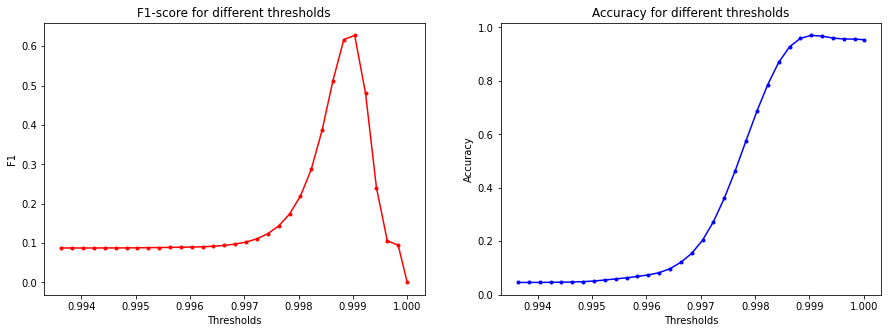

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_socres(thresholds,f_score,axes[0],'F1',"Thresholds","F1-score for different thresholds",label="F",color_curve = "RED")
plot_socres(thresholds,accuracy,axes[1],'Accuracy',"Thresholds","Accuracy for different thresholds",label="Accuracy",color_curve="BLUE")
plt.show()

In [ ]:
genuine_dist,imposter_dist = get_genuine_imposter_score(mask_id,sim_vector)

####Plot the genuine and imposter score.

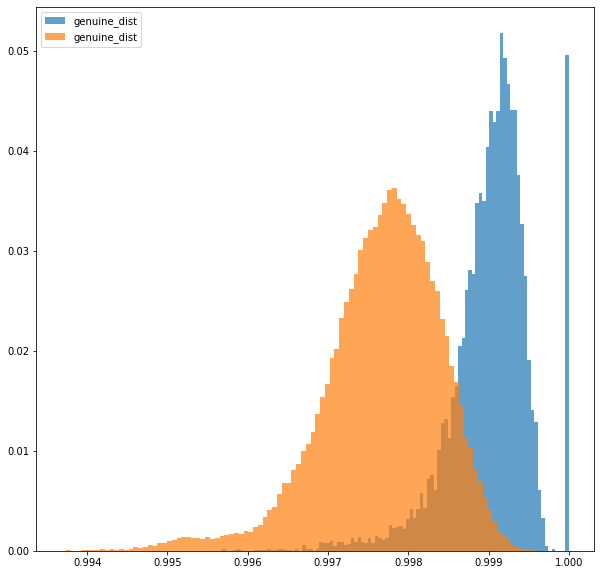

In [ ]:
#Set the size of the figure.
plt.figure(figsize=(10,10))
#First create the weights for normalized version of the plots.
weights = np.ones_like(genuine_dist)/float(len(genuine_dist))
weights2 = np.ones_like(imposter_dist)/float(len(imposter_dist))
#Parameters that define type of the curve and number of bins.
kwargs = dict(histtype='stepfilled', alpha=0.7,  bins=100)
#Finally plot the histogram.
plt.hist(genuine_dist,**kwargs, weights=weights,label='genuine_dist')
plt.hist(imposter_dist,**kwargs, weights=weights2,label='genuine_dist')
plt.legend()
plt.show()

####Next we picked task 6 where we implement a custom face recognition algorithm/architecture with deep learning.

In [ ]:
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Input, Cropping2D, add, Dropout, Reshape, Activation,MaxPooling2D,Flatten,Dense
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras import regularizers


####The following section define the model. Note that it is a custom model and does not refer to any already existing architecture.

In [ ]:
def get_custom_model():
    custom_model = Sequential()
    custom_model.add(Conv2D(32, 3, padding='same', input_shape=(47,47,1)))
    custom_model.add(Activation('relu'))
    custom_model.add(Conv2D(64, 3, 3))
    custom_model.add(Activation('relu'))
    #custom_model.add(MaxPooling2D(pool_size=(2, 2)))
    custom_model.add(Dropout(0.25))
    custom_model.add(Conv2D(64, 3, padding='same'))
    custom_model.add(Activation('relu'))
    custom_model.add(Conv2D(100, 3, 3))
    custom_model.add(Activation('relu'))
    custom_model.add(MaxPooling2D(pool_size=(3, 3)))
    custom_model.add(Dropout(0.25))
    custom_model.add(Flatten())
    custom_model.add(Dense(100))
    custom_model.add(Activation('relu'))
    custom_model.add(Dropout(0.25))
    custom_model.add(Dense(26)) #Equal to classes
    custom_model.add(Activation('softmax'))
    return custom_model

####Get the summary of the model.

In [ ]:
model = get_custom_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 47, 47, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 15, 64)       

####Compile the model.

In [ ]:
sgd = optimizers.SGD(lr=1E-4, decay=5**(-3), momentum=0.5, nesterov=True)
adam = Adam(lr=1e-4)
acc = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)

model.compile(
    loss="categorical_crossentropy",
    optimizer=adam,
    metrics=[acc])

#### Split the data into train,test and validation dataset. Note that we only use provided dataset and VGGfaceDataSet is not used.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(faces.images, faces.target, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 


#### We tried the model with sparse_categorical_cross entropy and with one image as target but it did not work. So we have to use simple cross_entropy which requires that we have N masks where N is number of classes.

####The following function takes an array and returns the masks

In [ ]:
def get_targets(y_train):
    min_val = np.amin(faces.target)
    max_val = np.amax(faces.target)
    targs = [None]*len(y_train)
    for i in range(len(y_train)):
        targets_mod = [0]*(max_val+1)
        targets_mod[y_train[i]] = 1
        targs[i] = targets_mod
    targs = np.array(targs)
    return targs

####We call the function defined above and get the results.

In [ ]:
targs = get_targets(y_train)
targs_val = get_targets(y_val)

####Early stopping is used to avoid overfitting.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

####We finally fit the model.

In [ ]:
history = model.fit(X_train, targs,validation_data=(X_val, targs_val),batch_size=17,
                       epochs=1000, shuffle=True,callbacks=[callback])

Epoch 1/1000
16/16 [==============================] - 0s 20ms/step - loss: 17.2106 - categorical_accuracy: 0.0455 - val_loss: 4.6275 - val_categorical_accuracy: 0.0568
Epoch 2/1000
16/16 [==============================] - 0s 6ms/step - loss: 8.1176 - categorical_accuracy: 0.0379 - val_loss: 3.7666 - val_categorical_accuracy: 0.0341
Epoch 3/1000
16/16 [==============================] - 0s 5ms/step - loss: 5.4851 - categorical_accuracy: 0.0530 - val_loss: 3.4285 - val_categorical_accuracy: 0.0455
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 4.4067 - categorical_accuracy: 0.0455 - val_loss: 3.3238 - val_categorical_accuracy: 0.0568
Epoch 5/1000
16/16 [==============================] - 0s 6ms/step - loss: 4.0191 - categorical_accuracy: 0.0303 - val_loss: 3.2752 - val_categorical_accuracy: 0.0455
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 3.8160 - categorical_accuracy: 0.0341 - val_loss: 3.2962 - val_categorical_accuracy: 0.0114
Ep

### We now plot the accuracy and loss of the model.

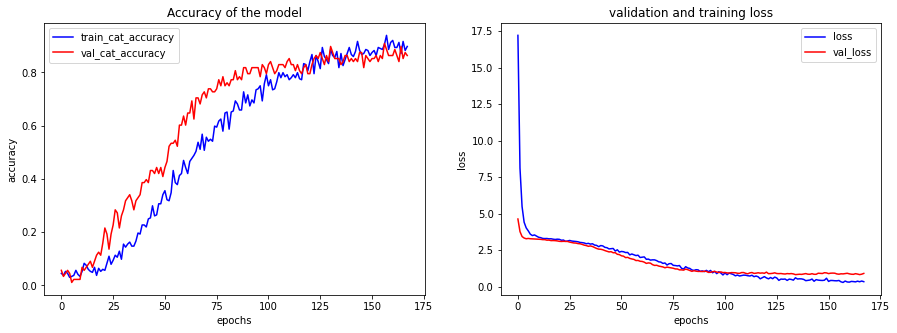

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(history.history['categorical_accuracy'],color="BLUE",marker="",label='train_cat_accuracy')
axes[0].plot(history.history['val_categorical_accuracy'],color="RED",marker="",label='val_cat_accuracy')
axes[0].set_xlabel("epochs")
axes[0].set_ylabel("accuracy")
axes[0].title.set_text("Accuracy of the model")
axes[0].legend()
axes[1].plot(history.history['loss'],color="BLUE",marker="",label='loss')
axes[1].plot(history.history['val_loss'],color="RED",marker="",label='val_loss')
axes[1].set_xlabel("epochs")
axes[1].set_ylabel("loss")
axes[1].title.set_text("validation and training loss")
axes[1].legend()
plt.show()

####Next we try to predict things on testdata.

####Check if both lists have equal number of label/predictions.

####Convert the test targets into masks.

In [ ]:
test_targs = get_targets(y_test)

In [ ]:
score, acc = model.evaluate(X_test, test_targs,
                            batch_size=17)
print('Test score:', score)
print('Test accuracy:', acc)

6/6 [==============================] - 0s 2ms/step - loss: 0.4094 - categorical_accuracy: 0.9205
Test score: 0.4093705415725708
Test accuracy: 0.9204545617103577


####We have very slight differences between accuracy of this model with siamese network.